<a href="https://colab.research.google.com/github/nirro88/annotation-tool/blob/main/data_science_home_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
# max rows and columns to display
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam

# Load the tables into pandas DataFrames
rainfall_df = pd.read_csv('/rainfall.csv')
faults_df = pd.read_csv('/table_1.csv')
# change the column names to lowercase with underscores
rainfall_df.columns = rainfall_df.columns.str.lower().str.replace(' ', '_')
faults_df.columns = faults_df.columns.str.lower().str.replace(' ', '_')

In [ ]:
rainfall_df.head()

,year,month,average_monthly_rain
0,2019,Jun,0.0
1,2019,Jul,0.0
2,2019,Aug,0.0
3,2019,Sep,0.0
4,2019,Oct,30.3


In [ ]:
faults_df.head()

,order_number,train_car,fault,fault_date,order
0,4315343.0,DD00407,K100 קדב,29/03/2020,YRS2
1,4443359.0,DD00413,ןיקת אל ןמש ןגא םמחמ,3/10/2022,YRS1
2,4505818.0,DD00415,רצקמ הלעמל 2 הצק ןמש ןגא םממחמ,25/12/2023,YRS1
3,4470866.0,DD00416,K100 קדב,11/6/2023,YRS2
4,4391120.0,DD00417,1Y - ץיקל הנכה קדב,10/3/2022,YRS2


### Q1: Given the frequency of reported faults in the oil heaters, can you design a predictive maintenance model that can predict future faults? Please outline the type of data you would require and the algorithm you would use.

Data requirements:
the data required for this task is sensors data:
- Temperatures - oil temperature and oil level.
- Pressure of air and fluids.
- Electrical signal of all relevant components in the system.
- Noise sensor – can detect sounds of machinery at work.
- Vibration sensors.
- The time of installing\replacement the components.
- Manufacturing data of the component.
preferable in intervals that can help us in detecting the patterns like seasonality and trend.


steps for solving the problem:
1. Data collection - Load the tables into pandas DataFrames
2. Data cleaning and preparation
    - Create a new DataFrame for prediction named main_df
    - remove the rows with word 'בדק' soggesting that the machine was checked and no fault was found
    - We will generate a date range from the minimum to the maximum fault date
    - Add the target variable column named 'is_fault', If the date equals a fault_date, then 1, else 0
    - Add the column 'days_since_last_fault' to main_df
    - evoide data leakage change all places where time_from_last_fault = 0 to the value of time_from_last_fault in the row before + 1
    - Add the 'Average monthly rain' to main_df using month and year
    -  add winter and summer pointer columns to main_df
    
3. Model building
    - split to train test, scalling
    - train the model, create lstm model for classification task
4. Model evaluation
    - plot the results
    - calculate the precision, recall, f1 score, auc score
    - plot auc curve

In [ ]:
# Begin preprocessing stage
# Step 1: Convert 'Fault date' to datetime format
faults_df['fault_date'] = pd.to_datetime(faults_df['fault_date'])

print(len(faults_df))
# drop rows where fault is 'בדק' - 'קדב'
# Ensure that the 'fault' column is of string type and handle NaN values
faults_df['fault'] = faults_df['fault'].fillna('')

# Now you can safely use str.contains with the bitwise NOT operator
faults_df = faults_df[~faults_df['fault'].str.contains('קדב')]

print(len(faults_df))

# Step 2: Create a new DataFrame for prediction named main_df
# We will generate a date range from the minimum to the maximum fault date
date_range = pd.date_range(start=faults_df['fault_date'].min(), end=faults_df['fault_date'].max())
main_df = pd.DataFrame(date_range, columns=['date'])

# Step 3: Add the target variable column named 'is_fault'
# If the date equals a fault_date, then 1, else 0
main_df['is_fault'] = main_df['date'].isin(faults_df['fault_date']).astype(int)

# Step 3.5: Add the fault column to main_df
# If the date equals a fault_date, add the fault name, else ' '
# Create a dictionary from faults_df with 'fault_date' as keys and 'fault' as values
fault_dict = pd.Series(faults_df['fault'].values, index=faults_df['fault_date']).to_dict()

# Map the fault names to the main_df dates using the dictionary
# If there is no fault on a date, fill with a space or some other placeholder
main_df['fault'] = main_df['date'].map(fault_dict).fillna(' ')

# Now main_df has a new 'fault' column with the corresponding fault names from faults_df

# print the distribution of the target variable
print(main_df['is_fault'].value_counts(normalize=True))


# # Step 4: Build a variable 'time_from_last_fault'
# # Count days from the last fault for each row
# create a new column time_from_last_fault , for each row count days from the last fault using is_fault column
# for each row if is_fault = 1 then time_from_last_fault = 0 else time_from_last_fault = time_from_last_fault + 1
list_time_from_last_fault = []
for i in range(len(main_df)):
    if main_df['is_fault'][i] == 1:
        list_time_from_last_fault.append(0)
    else:
        list_time_from_last_fault.append(list_time_from_last_fault[i-1] + 1)
main_df['time_from_last_fault'] = list_time_from_last_fault

# to evoide data leakage change all places where time_from_last_fault = 0
# to the value of time_from_last_fault in the row before + 1
# for i in range(len(main_df)):
#     if i == 0:
#         continue
#     if main_df['time_from_last_fault'][i] == 0:
#         main_df['time_from_last_fault'][i] = main_df['time_from_last_fault'][i-1] +1

for i in range(1, len(main_df)):
    if main_df.loc[i, 'time_from_last_fault'] == 0:
        main_df.loc[i, 'time_from_last_fault'] = main_df.loc[i - 1, 'time_from_last_fault'] + 1


# Step 5: Create month and year columns using the 'date' column
main_df['month'] = main_df['date'].dt.month
main_df['year'] = main_df['date'].dt.year

# Step 6: Add the 'Average monthly rain' to main_df using month and year
# First convert 'Year' and 'Month' in rainfall_df to datetime to merge with main_df
rainfall_df['year'] = rainfall_df['year'].astype(int)
# rainfall_df['date'] = pd.to_datetime(rainfall_df['year'] + rainfall_df['month'], format='%Y%B')
# change the months column to numbers
rainfall_df['month'] = rainfall_df['month'].replace({'Jan': 1, 'Fab': 2, 'Mar': 3, 'Apr': 4,
                                                     'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
                                                     'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}).astype(int)

# add average monthly rain to main_df using month and year
main_df = main_df.merge(rainfall_df[['year', 'month', 'average_monthly_rain']], on=['year', 'month'], how='left')

# add winter and summer to main_df using month
main_df['winter'] = main_df['month'].isin([11, 12, 1, 2, 3]).astype(int)

# convert year and month to categorical columns using pandas get_dummies as 1,0 values
# main_df = pd.get_dummies(main_df, columns=['year', 'month']).astype(int)
# main_df = pd.get_dummies(main_df, columns=['year', 'month'])
# main_df = pd.get_dummies(main_df.drop(columns=['date']), columns=['year', 'month'])


# Use pd.get_dummies() to encode 'year' and 'month' as 1's and 0's
# main_df = pd.get_dummies(main_df, columns=['year'], drop_first=False,dtype=int)

# change year columns year_2019,year_2020,year_2021,year_2022,year_2023,year_2024 -  to 1,0
# main_df['year_2019'] = main_df['year_2019'].astype(int)

# cha

main_df.head(10)

114
94
0    0.965603
1    0.034397
Name: is_fault, dtype: float64


<ipython-input-4-359821ced13a>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  faults_df['fault_date'] = pd.to_datetime(faults_df['fault_date'])


,date,is_fault,fault,time_from_last_fault,month,year,average_monthly_rain,winter
0,2019-03-07,1,רצקמ F1261 תיימאמ,0,3,2019,NaN,1
1,2019-03-08,0,,1,3,2019,NaN,1
2,2019-03-09,0,,2,3,2019,NaN,1
3,2019-03-10,0,,3,3,2019,NaN,1
4,2019-03-11,0,,4,3,2019,NaN,1
5,2019-03-12,0,,5,3,2019,NaN,1
6,2019-03-13,0,,6,3,2019,NaN,1
7,2019-03-14,0,,7,3,2019,NaN,1
8,2019-03-15,0,,8,3,2019,NaN,1
9,2019-03-16,0,,9,3,2019,NaN,1


In [ ]:
# Define X and y
X = main_df[['time_from_last_fault', 'month', 'year', 'average_monthly_rain','winter']]
y = main_df['is_fault']

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
# Check for NaN values in the original dataset
if X_scaled.isna().any().any():
    print("NaN values present in the dataset. Consider handling them before scaling.")
    print(X_scaled.isna().sum())
    X_scaled = X_scaled.fillna(0)
print(X_scaled.isna().sum())
X_scaled.head()

NaN values present in the dataset. Consider handling them before scaling.
time_from_last_fault      0
month                     0
year                      0
average_monthly_rain    331
winter                    0
dtype: int64
time_from_last_fault    0
month                   0
year                    0
average_monthly_rain    0
winter                  0
dtype: int64


,time_from_last_fault,month,year,average_monthly_rain,winter
0,0.000000,0.181818,0.0,0.0,1.0
1,0.004016,0.181818,0.0,0.0,1.0
2,0.008032,0.181818,0.0,0.0,1.0
3,0.012048,0.181818,0.0,0.0,1.0
4,0.016064,0.181818,0.0,0.0,1.0


In [ ]:

# Define the sequence length (number of time steps)
sequence_length = 5

# Function to create sequences
def create_sequences(input_data, target, sequence_length):
    sequences = []
    target_sequences = []
    for i in range(len(input_data) - sequence_length):
        sequences.append(input_data[i:i + sequence_length])
        target_sequences.append(target[i + sequence_length])
    return np.array(sequences), np.array(target_sequences)

# Create sequences for LSTM model
X_sequences, y_sequences = create_sequences(X_scaled.values, y.values, sequence_length)

# Split the data into training and testing sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_sequences, test_size=0.2, random_state=42, stratify=y_sequences)

# Define a function to create the LSTM model
def create_lstm_model(input_shape):
    adam = Adam(learning_rate=0.001)
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['AUC'])
    return model

# Create the LSTM model
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))

# Train the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0, validation_split=0.1)

# Predict the probabilities on the test set
y_pred_proba = lstm_model.predict(X_test)





13/13 [==============================] - 1s 3ms/step


In [ ]:
y_pred_proba

array([[4.89213243e-02],
       [8.92239530e-03],
       [1.19695850e-01],
       [2.05923826e-01],
       [1.80039387e-02],
       [1.91762280e-02],
       [3.35675701e-02],
       [9.40224063e-03],
       [9.66653228e-03],
       [1.12363726e-01],
       [1.90337852e-01],
       [3.75585407e-02],
       [1.71887875e-02],
       [2.32897382e-02],
       [4.65643185e-04],
       [2.29871110e-03],
       [3.24074179e-02],
       [9.06535052e-03],
       [1.39996177e-02],
       [3.02578118e-02],
       [5.13318740e-02],
       [1.36877336e-02],
       [1.70714706e-02],
       [1.27637293e-02],
       [1.43442620e-02],
       [4.74746712e-02],
       [2.02171624e-01],
       [2.19952315e-02],
       [2.62842700e-02],
       [2.19942909e-02],
       [1.90495197e-02],
       [2.10462822e-04],
       [2.23902032e-01],
       [2.52541649e-04],
       [3.94712761e-02],
       [1.24789990e-01],
       [1.66285336e-02],
       [1.98987145e-02],
       [1.28204245e-02],
       [1.67391542e-02],


In [ ]:


y_pred = np.where(y_pred_proba > 0.1, 1, 0)
# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)
print('AUC score:', auc_score)
# calculate precision and recall and f1 score
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_pred, average='binary')
print('precision_recall_fscore_support:', precision_recall_fscore_support(y_test, y_pred, average='binary'))

AUC score: 0.6723883351790328
precision_recall_fscore_support: (0.1, 0.35714285714285715, 0.15625, None)


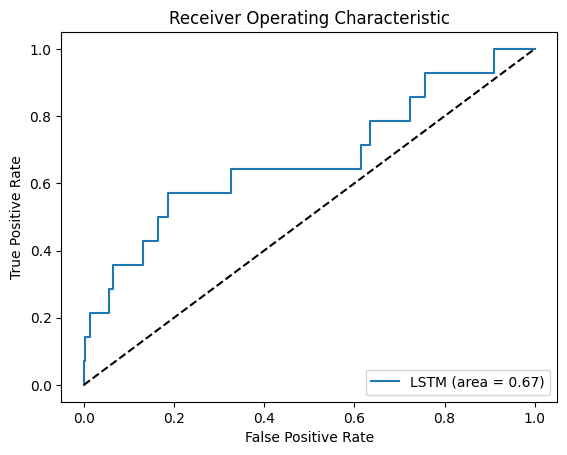

In [ ]:
# Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label='LSTM (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

### Q2: How would you analyze the data set provided to determine if there are patterns or trends in failures related to specific train models or specific seasons?

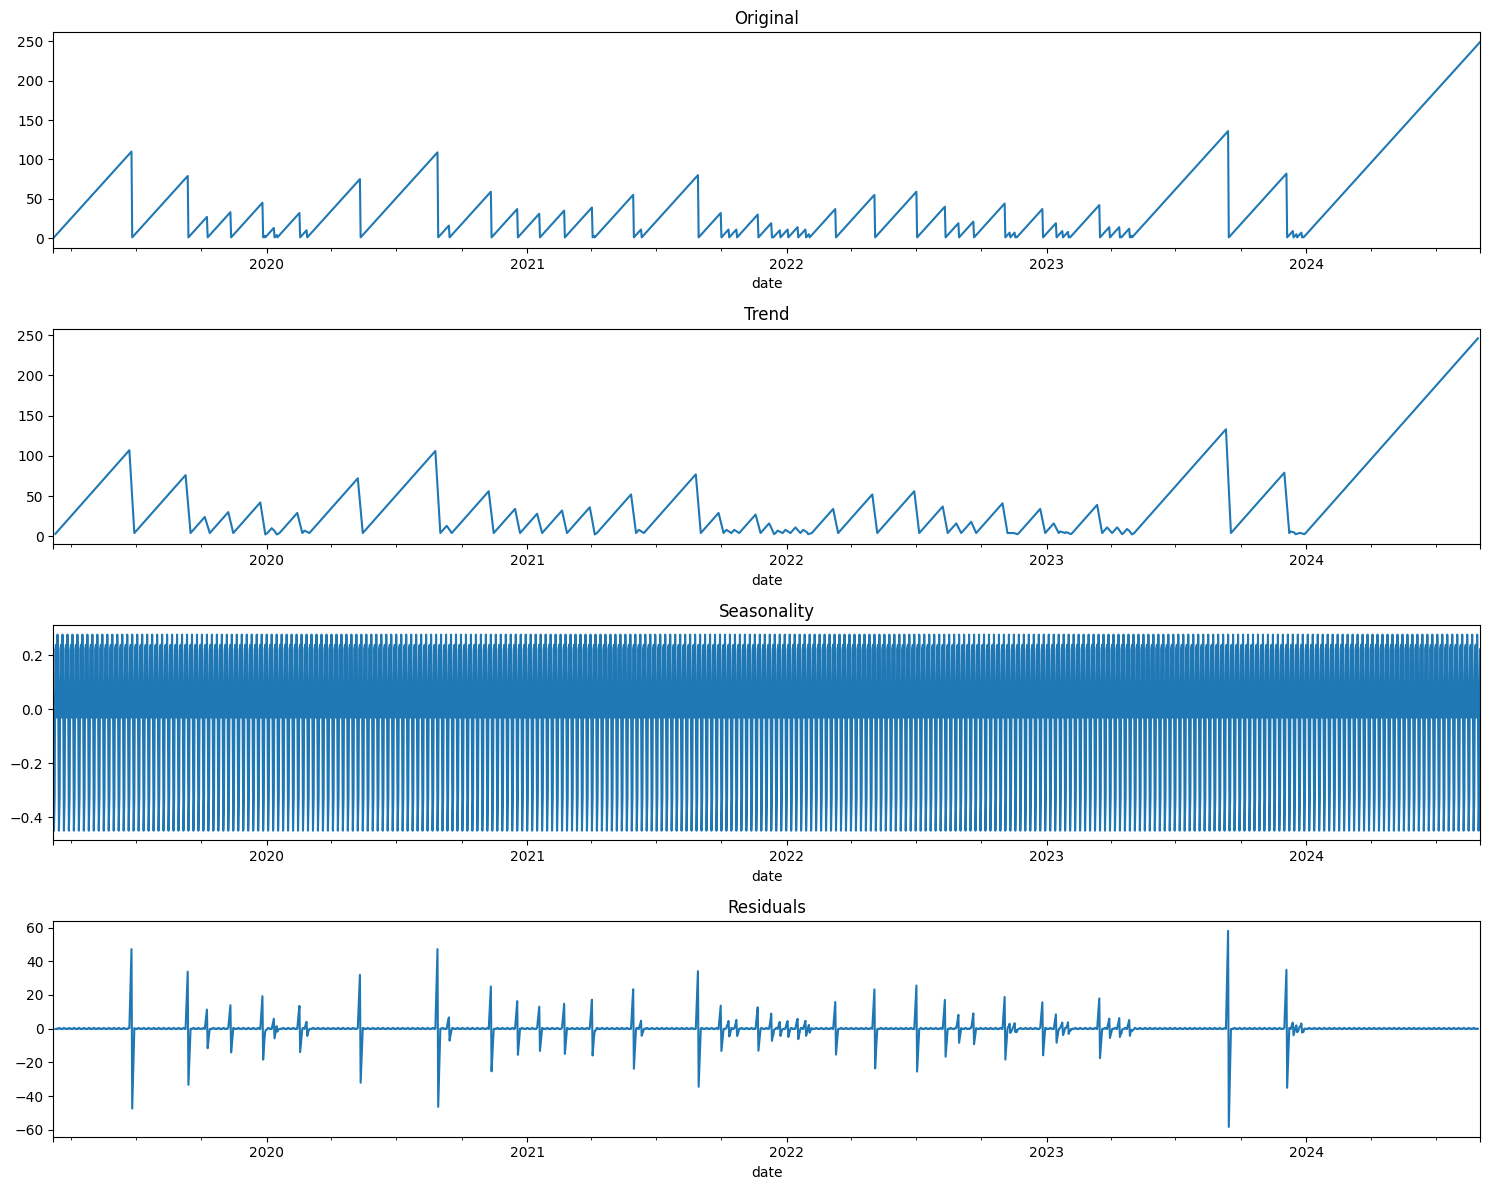

In [ ]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming 'time_series_df' is your DataFrame and it contains a time series column named 'variable'
# Also assuming 'date_column' is your date column in 'time_series_df'

# Convert the date column to datetime and set it as the index
# time_series_df['date_column'] = pd.to_datetime(time_series_df['date_column'])
main_df.set_index('date', inplace=True)

# Perform seasonal decomposition
# The model can be 'additive' or 'multiplicative', depending on the nature of the time series
# assuming variations are roughly constant through the series.
decomposition = seasonal_decompose(main_df['time_from_last_fault'], model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Original')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')

plt.tight_layout()
plt.show()


Original: The plot shows fluctuations over time, with some apparent trends and possibly some seasonal patterns. There are noticeable peaks at regular intervals which might suggest seasonality or recurring events.

Trend: This plot extracts the underlying trend from the original data, smoothing out the seasonality and irregular components. It helps to identify the long-term movement in the data. The trend plot shows some significant changes over time, including some sharp increases and decreases, which might indicate external events affecting the data.

Seasonality: This plot shows the seasonal component that has been extracted from the original data. It highlights the regular pattern that repeats over time. The seasonality here appears to be very consistent and strong, indicating that the time series has a clear seasonal pattern. The frequency and amplitude of the seasonal component seem to be constant over time, suggesting an additive seasonal effect.

Residuals: These are the irregularities or the 'noise' that remain after the trend and seasonal components have been removed from the original data. Ideally, the residuals should be relatively small and show no pattern. In this plot, the residuals are mostly centered around zero, but there are some outliers. Some structure might still be present in the residuals, suggesting that the model hasn't captured all aspects of the data's behavior.

it appers that in columns 'time_from_last_fault', 'average_monthly_rain' there is some variation regarding the groups is_fault 1,0

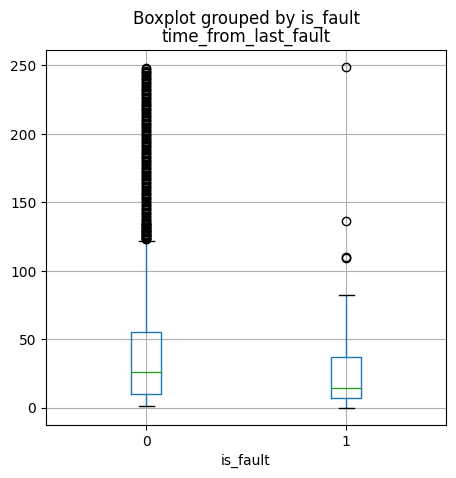

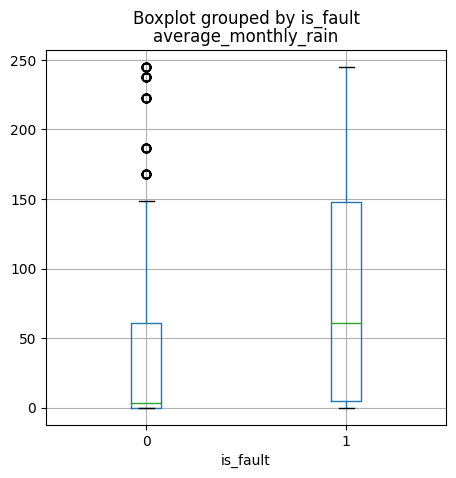

In [ ]:
# using box plot variation between groups is_found = 0 and is_found = 1 in respect to time_from_last_fault
for col in ['time_from_last_fault', 'average_monthly_rain']:
    if col == 'is_fault':
        continue
    main_df.boxplot(column=col, by='is_fault', figsize=(5, 5))
    plt.title(col)
    plt.show()


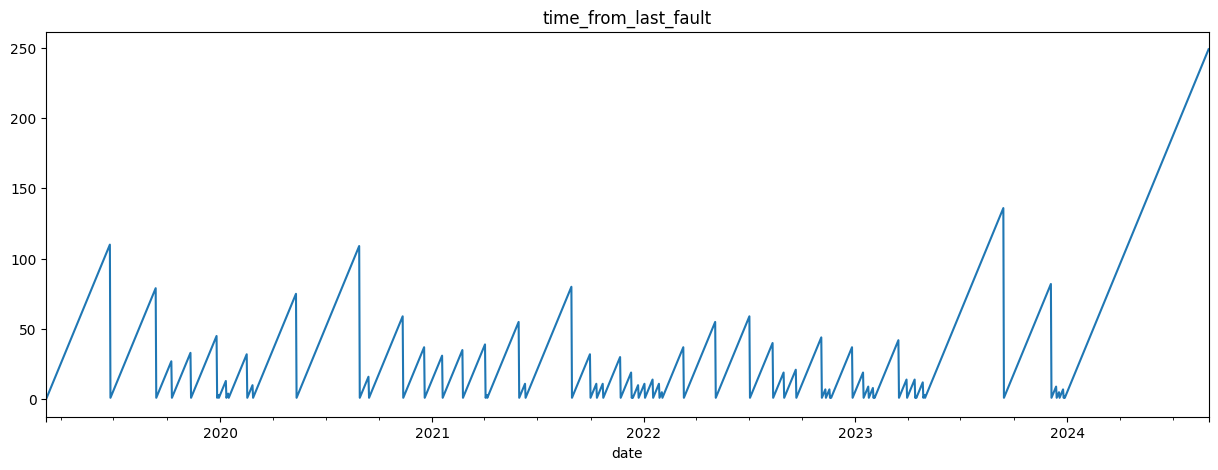

In [ ]:
# plot the line graph of time_from_last_fault in respect to date
main_df['time_from_last_fault'].plot(figsize=(15, 5))
plt.title('time_from_last_fault')
plt.show()

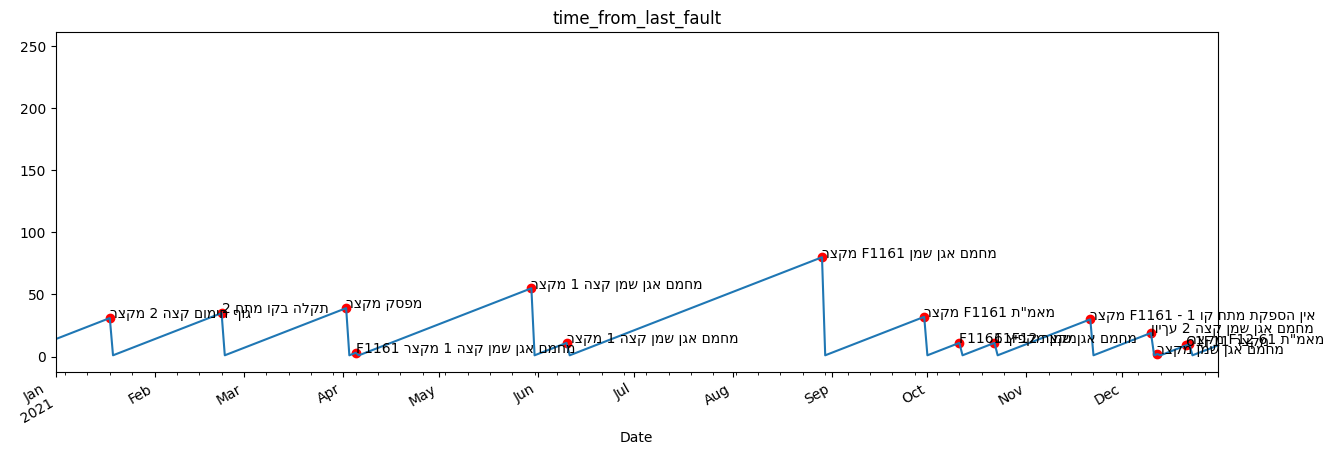

In [ ]:
# lets try to focus on the year 2021 when the year column is 2021 add full date to the plot
main_df[main_df['year'] == 2021]['time_from_last_fault'].plot(figsize=(15, 5))
# add the fault as points to the plot whether the fault is 1
plt.scatter(main_df[main_df['is_fault'] == 1].index, main_df[main_df['is_fault'] == 1]['time_from_last_fault'], color='red')
# add type of fault as text using to the plot whether the fault is 1 and the date is 2021
for i in range(len(main_df)):
    if main_df['is_fault'][i] == 1 and main_df['year'][i] == 2021:
        plt.text(main_df.index[i], main_df['time_from_last_fault'][i], main_df['fault'][i])

# display the dates every 7 days
plt.xlabel('Date')
plt.title('time_from_last_fault')
plt.gcf().autofmt_xdate()  # Auto-format the dates for better readability
plt.show()

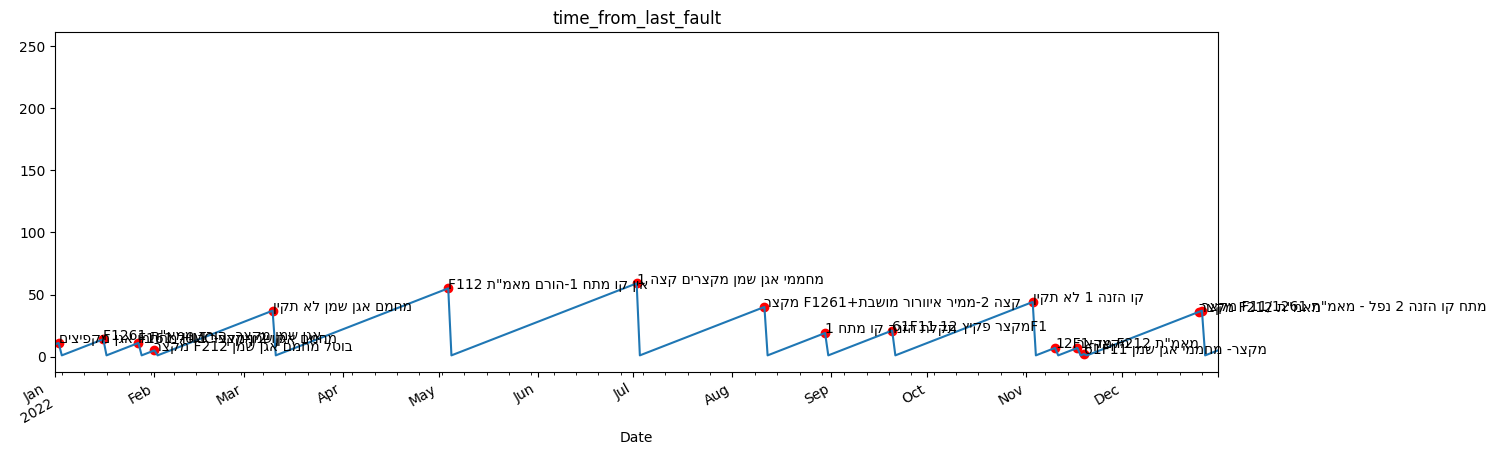

In [ ]:
# lets try to focus on the year 2022 when the year column is 2022 add full date to the plot
main_df[main_df['year'] == 2022]['time_from_last_fault'].plot(figsize=(15, 5))
# add the fault as points to the plot whether the fault is 1
plt.scatter(main_df[main_df['is_fault'] == 1].index, main_df[main_df['is_fault'] == 1]['time_from_last_fault'], color='red')
# add type of fault as text using to the plot whether the fault is 1 and the date is 2021
for i in range(len(main_df)):
    if main_df['is_fault'][i] == 1 and main_df['year'][i] == 2022:
        plt.text(main_df.index[i], main_df['time_from_last_fault'][i], main_df['fault'][i])

# display the dates every 7 days
plt.xlabel('Date')
plt.title('time_from_last_fault')
plt.gcf().autofmt_xdate()  # Auto-format the dates for better readability
plt.show()

### it seams that faults are more likely to happen in the winter and in the summer

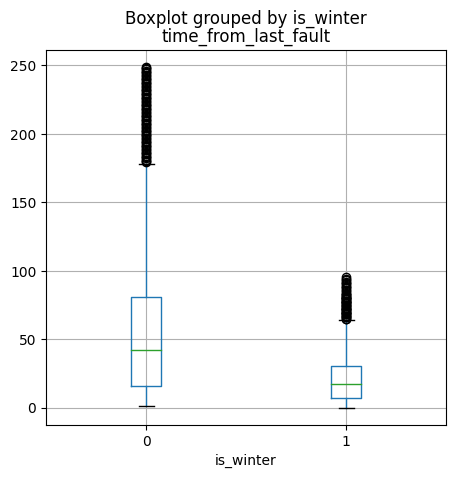

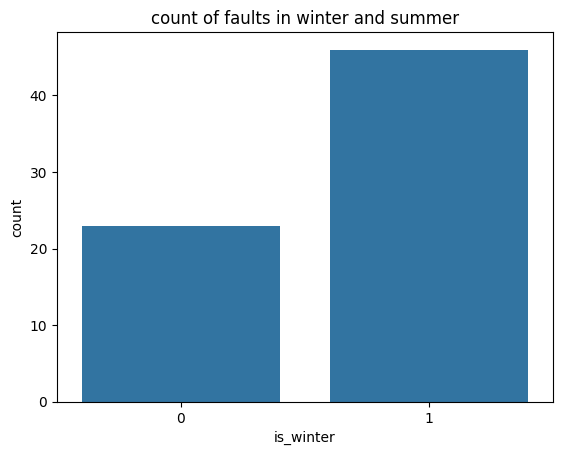

In [ ]:
# create a new column 'is_winter' in main_df
# if the month is 12 or 1 or 2 then is_winter = 1 else is_winter = 0
main_df['is_winter'] = main_df['month'].isin([10,11,12, 1, 2,3]).astype(int)
# plot some box plots to see the variation between groups
for col in ['time_from_last_fault']:
    if col == 'is_fault':
        continue
    main_df.boxplot(column=col, by='is_winter', figsize=(5, 5))
    plt.title(col)
    plt.show()
# make a count plot of is_winter to count the number of faults in winter and summer motnhs

# display the number of faults in winter and summer
sns.countplot(x='is_winter', data=main_df.loc[main_df['is_fault'] == 1])
plt.title('count of faults in winter and summer')
plt.show()


### Q3: Can you suggest a data visualization technique that would allow maintenance managers to easily identify the most common faults in train car oil heaters and the time it takes to fix them?


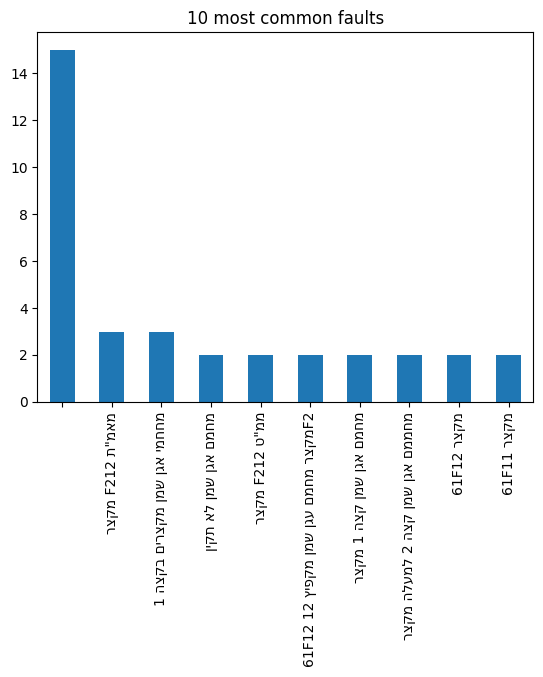

In [ ]:
# if dont have the time it takes to fix them so we can just plot the k most common faults
faults_df['fault'].value_counts().head(10).plot(kind='bar')
plt.title('10 most common faults')
plt.show()


### Q4: Suppose you have access to weather data. How would you correlate the temperature, rain, etc. and fluctuations with the frequency of oil heater failures, and what insights could you draw from this analysis to improve the reliability of the heating system?

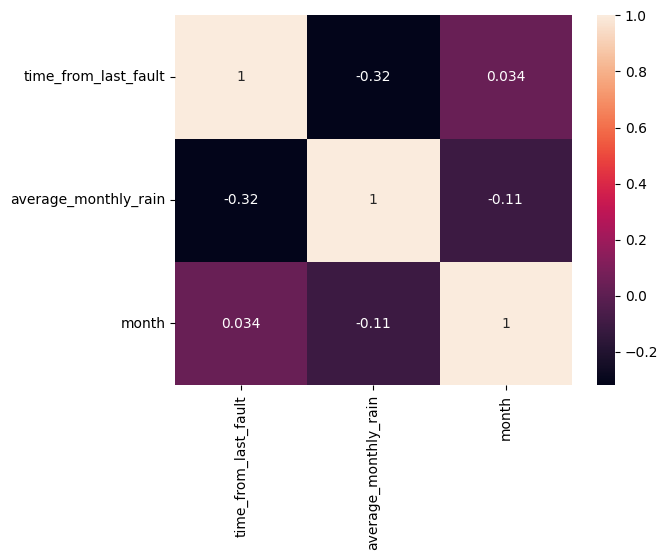

In [ ]:
# check for corelation between the features last_fault_time and average_monthly_rain using heatmap
sns.heatmap(main_df[['time_from_last_fault', 'average_monthly_rain','month']].corr(), annot=True)
plt.show()



### we can see some corelation between the features
### also we saw erlier that the the month with higher average rain have more faults
### and the winter have more faults then the summer so we can assume that the rain is a factor in the faults or the temperature

### Q5: Based on the fault data provided, how would you identify the critical factors leading to oil heating malfunctions (if possible) and what statistical methods would you use to support your findings?

1.	If you refer to causation of one variable on the failure/malfunctions it is a very challenging case.
We can measure the temperature of oil (a continues variable) and check for correlation to other continues variables.
2.	Use spectrum of amplitude vs frequency (or other spectrum of sensor data), detect the spikes which can be a case of abnormal activity, check if they occur at same time of failure events, if yes, it is possible critical factures.

3.	We can also check if there is a chain of events of failure in some component leading to oil heat (if we observed few times in repeat, we can make assumption).
For example, the reduction of oil level followed by high frequency or load is leading to heat of temperature in oil.


4. we saw with columns 'time_from_last_fault', 'average monthly rain' that faults have different distributions, might suggest that there is a possible chain of events that lead to a fault.

5. also it appers that the month of winter have a higer rate of faults then the summer, might suggest that the temperature is a factor in the faults.

### Q6: What maintenance recommendation system using machine learning could prioritize which train car oil heaters should be inspected next based on past failure data? Please describe the features you would include in your model.

### if we had more data about the life time of the components we could use it to Predict remaining useful life (RUL) of the components and then we could prioritize the components that are close to the end of their life

Model 2 - Predict remaining useful life (RUL):
Predicting the Remaining Useful Life (RUL) of equipment, like oil heaters involves using historical data to estimate the time until a piece of equipment is likely to fail.
This model can help us prioritize the maintenance of train equipment.
After learning the RUL for every type of failure we can check if a component is reaching the end of its life and inspect it

The steps to tackle RUL prediction:
1.	Data Collection and Preprocessing
 - Historical Data: Gather historical data on oil heater operations, including maintenance records, failure history, and operational parameters.
 - Basically we collect a snap shot of data at every time of a component life, so in every sample the x is the data of the component at the specific time and the y is the remaining time before failure.
 - Feature Engineering: Create features that are indicative of wear and tear, such as age of the heater, usage hours, frequency, and type of maintenance.
 - Also, it is possible to do some aggregation: mean, max, min and std variables as per hour.
 - Handling Censored Data: In many cases, not all units will have reaches failure, leading to censored data. Models need to account for this to avoid bias.
 - Normalization: Standardize the data to ensure consistent scale across different features.
 - Create target variable – remaining time of life, here we need to distinguish between two types of repairs, 1- repair and 2- replace with new component. It will affect the time of life. Maybe create categorical variable for this aspect.

2.	Exploratory Data Analysis (EDA)
a)	Identify Patterns: Look for patterns related to failures and maintenance in the historical data.
b)	Correlation Analysis: Determine which features are most strongly correlated with equipment failure.

3.	Model Selection
a)	Regression Models: Use regression models if RUL is considered as a continuous variable. Options include linear regression, ridge regression, or more complex models like random forest regressors and gradient boosting regressors.
b)	Deep Learning Models: For complex datasets, neural networks like Long Short-Term Memory (LSTM) networks can capture intricate patterns in time-series data.

4.	Model Training and Validation
a)	Train-Test Split: Divide the data into training and testing sets.
b)	Cross-Validation: Use techniques like k-fold cross-validation to ensure the model generalizes well.

5.	Feature Importance
Analysis: Determine which features are most predictive of RUL. This could inform maintenance decisions.

6.	Model Evaluation
    -We would expect the target variable is not normally distributed (heavy tail, skewness) maybe have a Log-Normal Distribution.
    - We need to address this issue when make a predictions (Apply a logarithmic transformation to the target and then For evaluation and interpretation, back-transform the model’s predictions by applying the exponential function to convert them back to the original scale).
    - Performance Metrics: Use metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or R-squared to evaluate the performance of the RUL predictions.

Key Assumptions in RUL Models
1.	Consistent Operational Context:
It’s often assumed that the operational context (usage conditions, load, environment) remains consistent over the equipment's lifecycle, which isn’t always the case.
2.	Failure Definition:
The model assumes a clear definition of 'failure', which can vary significantly across different equipment and use cases.
3.	Degradation Uniformity:
There’s an implicit assumption that the degradation process is uniform and predictable, which might not account for sudden failures due to external factors.
4.	Data Representativeness:
The historical data used to train the model is assumed to be representative of future operational conditions.
5.	Model Stability Over Time:
It’s often assumed that the model remains stable over time, whereas in reality, changes in operational practices, maintenance strategies, or equipment modifications can affect its accuracy.
6.	Censoring Mechanism:
In the case of censored data, it’s assumed that the censoring process (why some units haven't failed yet) is not biased.


### Q7: How would you use time series analysis to predict when the next oil heater failure will occur? What type of data pre-processing would be required for this analysis?

- in Q1 we saw an example of time series analysis, we can use it to predict the next failure

- another option is to useing a model that will predict the remaining life time of the components and then we could prioritize the components that are close to the end of their life described in Q6

- another option is decribed bellow (regression-based anomaly detection)

1. Data requirements:
the data required for this task is sensors data:
    * Temperatures - oil temperature and oil level.
    * Pressure of air and fluids.
    * Electrical signal of all relevant components in the system.
    * Noise sensor – can detect sounds of machinery at work.
    * Vibration sensors.
    * The time of installing\replacement the components.
    * Manufacturing data of the component.
preferable in intervals that can help us in detecting the patterns like seasonality and trend.
The same time intervals(timestamps) are essential for predictions.
After collecting the row data, we generally want to a aggregate the mean, median, max, min and std per time intervals (hour,day) for each sensor\time series data.

#### design a predictive maintenance model that can predict future faults.
1. Model 1- predict future faults: Supervised learning (regression-based anomaly detection)
- build an algorithm for predictions of faults, anomaly detection technique.
- This method uses Regression based anomaly detections to find large errors in the residuals.
- We take the data sensor (time series) associated with the faults, for example heat sensor for the oil heaters.

##### Some key points for this model:
1. Data Preprocessing - time series data
    * Make a binary target column related to the sensor data (recognize the point of temperature when the component has failed).
    * Also, it is important to distinguish if the component was repaired or it was replaced by new one, it will help us evaluate the model performance after.
    * As said before, after collecting the row data, we generally want to aggregate the mean, median, max, min and std for each time series data sensor.
    * In some sensors like pressure its crucial to drop the transient area, the time between start of the component and the regular work (time from start until we get optimal pressure).
    * Cleaning: Remove or correct any missing values, there are times the sensor doesn’t need to work (train is at rest, during weekends).
    * Normalization/Standardization: Especially important if the range of data varies widely.

2. Feature Engineering - can make many features that needed such as:
    - Lag Features: Create lagged versions of time series data to capture temporal dependencies.
    - Rolling Window Statistics: Use rolling means, medians, or standard deviations to summarize recent trends.
3. Selecting the Right Model
    - Statistical Models: ARIMA, SARIMA for datasets with clear trends or seasonality (use AIC - Akaike Information Criterion, for hyperparameters tuning).
    - Machine Learning Models: LSTM (Long Short-Term Memory networks) for capturing complex patterns.
4. Training and Validation
    - Training: Fit the model to a portion of your time series data (using rolling window, for example train the first two weeks of month and test on third week and so on).
    - Cross-Validation: Use time series cross-validation, keeping the temporal order of data.
5. Make predictions and Evaluation.
    - Calculate the residuals - using a threshold to classify (if error is larger than some level) the abnormal points, the threshold can be determined by IQR method of the residuals.
    - Performance Metrics: evaluate between the binary column we created at the beginning and the predicted values.
    - use the metrics like precision, recall, F1-score, AUC.
    •	Visual Inspection: Plotting the anomalies detected against the time series data for manual inspection.


### Q8: What Key Performance Indicators (KPIs) would you include and how would you ensure that a dashboard is intuitive for non-technical users?

##### Designing a dashboard with Key Performance Indicators (KPIs) for non-technical users.
##### Key Performance Indicators (KPIs):
1.	Mean Time Between Failures (MTBF): Measures the average time between equipment failures, indicating reliability.
2.	Mean Time to Repair (MTTR): Shows the average time taken to repair equipment, reflecting maintenance efficiency.
3.	Failure Rate: The frequency of equipment failures within a specific period.
4.	Preventive Maintenance Compliance (PMC): The percentage of scheduled preventive maintenance tasks completed on time.
5.	Overall Equipment Effectiveness (OEE): Combines availability, performance, and quality to provide insight into overall operational efficiency.
6.	Downtime Duration: Total time that equipment is non-operational due to failures.
7.	Cost of Maintenance: Tracks the total cost associated with maintaining equipment.
8.	Safety Incidents: Number of safety incidents or accidents related to equipment.

##### Ensuring Intuitiveness for Non-Technical Users
- Simplicity is Key: Avoid clutter. Display only essential information to prevent information overload.
- Clear Visualizations: Use straightforward graphs like bar charts, line graphs, and pie charts. Ensure these are clearly labeled.
- Interactive Elements: Incorporate filters (time period, equipment type) to allow users to interact with the dashboard and find the information they need easily.
- Use of Colors and Icons: Utilize intuitive color coding (like red for high urgency or issues, green for optimal performance) and simple icons to convey information quickly.
- Dashboard Layout: Organize the KPIs logically. Group related metrics together and prioritize them based on importance.
- Tooltips and Help Text: Provide tooltips or help text that explain what each KPI means and why it’s important.
- Responsive Design: Ensure the dashboard is easily accessible and readable on various devices, including tablets and smartphones.
- User Testing and Feedback: Before finalizing, test the dashboard with actual end-users and incorporate their feedback to make it more intuitive.
- Documentation and Training: Provide easy-to-understand documentation or training sessions for users to get acquainted with the dashboard.


In [ ]:
# KPIs calculation
# KPI 1: MTBF (Mean Time Between Failures)
# MTBF = Total time / Number of failures, also can be the average of last_fault_time where is_fault = 1
mean_time_between_failures = main_df[main_df['is_fault'] == 1]['time_from_last_fault'].mean()
print('MTBF:', mean_time_between_failures)

# KPI failure rate
# calculate the frequency of failures per month
# frequency of failures = number of failures / number of months
# number of failures = number of rows where is_fault = 1
number_of_failures = main_df[main_df['is_fault'] == 1]['is_fault'].count()
frequency_of_failures = number_of_failures / main_df['month'].nunique()
print('frequency of failures per month:', frequency_of_failures)
# its a bit smaller because we have some months with no failures


MTBF: 30.304347826086957
frequency of failures per month: 5.75
